In [27]:
import matplotlib.pyplot as plt
import numpy as np

import lal
import lalsimulation as lalsim
import pycbc
import pycbc.waveform

In [28]:
import edward2.tensorflow as ed

In [29]:
import math

In [30]:
import tensorflow as tf

In [31]:
dist_scale = 1e6*lal.PC_SI
dist_scale

3.085677581491367e+22

In [32]:
hp, hc = pycbc.waveform.get_td_waveform(
    approximant='NRSur7dq4',
    mass1=30,
    mass2=30,
    f_lower=30,
    delta_t=1/4096.,
)

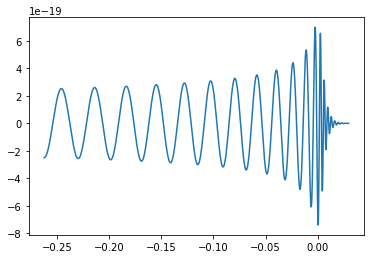

In [33]:
plt.figure()
plt.plot(hp.sample_times, hp)

In [34]:
hlm = pycbc.waveform.get_td_waveform_modes(
    approximant='NRSur7dq4',
    mass1=40,
    mass2=30,
    f_lower=30,
    delta_t=1/4096./2,
    delta_f=0.1,
    # mode_array = [ [2,2], [2,0] ]
)

In [35]:
hlm.keys()

dict_keys([(4, 4), (4, 3), (4, 2), (4, 1), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (3, 3), (3, 2), (3, 1), (3, 0), (3, -1), (3, -2), (3, -3), (2, 2), (2, 1), (2, 0), (2, -1), (2, -2)])

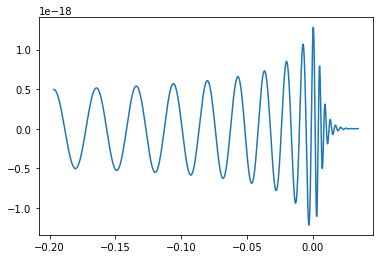

In [36]:
plt.figure()
plt.plot(hlm[(2,2)][0].sample_times, hlm[(2,2)][0])

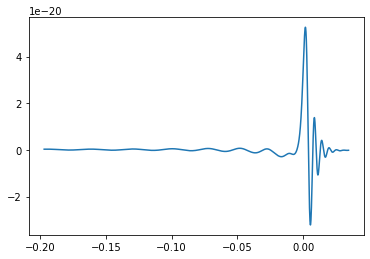

In [37]:
plt.figure()
plt.plot(hlm[(2,0)][0].sample_times, hlm[(2,0)][0])

In [38]:
plt.figure()
plt.plot(hlm[(4,4)][0].sample_times, hlm[(4,4)][0])
plt.xlim(-0.03,0.03)

(-0.03, 0.03)

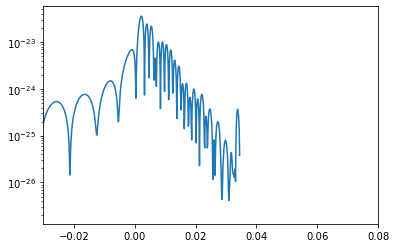

In [39]:
ell,m=(4,0)
plt.figure()
plt.plot(hlm[(ell,m)][0].sample_times, np.abs(hlm[(ell,m)][0]-1.j*hlm[(ell,m)][1]))
plt.xlim(-0.03,0.08)
plt.yscale('log')

# learning rate

In [40]:
def lrs_fn(epochs, batch_size, total_number_of_points, n_cycles_per_epoch=10, initial_lr=1e-3, t_mul=1.5, m_mul=0.9, alpha=0.0):

    # https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
    # steps_per_epoch = len(X_train) // batch_size
    steps_per_epoch = math.ceil(total_number_of_points / batch_size)
    # steps_per_epoch is the number of mini-batches per epoch
    # print(f"steps_per_epoch: {steps_per_epoch}")

    # n_cycles_per_epoch = 10
    # n_cycles_per_epoch = 1

    # lrs_kwargs = dict(
    #     initial_learning_rate=initial_lr,
    #     first_decay_steps=steps_per_epoch/n_cycles_per_epoch,
    #     t_mul=3.,
    #     m_mul=0.7,
    #     alpha=0.0,
    #     name=None
    # )

    lrs_kwargs = dict(
        initial_learning_rate=initial_lr,
        first_decay_steps=steps_per_epoch/n_cycles_per_epoch,
        t_mul=t_mul,
        m_mul=m_mul,
        alpha=alpha,
        name=None
    )

    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
    lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(**lrs_kwargs)
    
    return lrs

# modelling

In [41]:
def build_model(input_shape=(1, ), scale=1, num_inducing=1024, units=128, activation='relu', scale_2=1, num_inducing_2=1024):
    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=scale)
    bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)

    inputs = tf.keras.layers.Input(shape=input_shape)

    # x = tf.keras.layers.Dense(units, activation=activation)(inputs)
    x = tf.keras.layers.Dense(num_inducing, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, trainable=False)(inputs)
    x = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x)
    
#     x_0 = tf.keras.layers.Dense(num_inducing, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1), bias_initializer=tf.keras.initializers.RandomUniform(minval=-1., maxval=1.), trainable=False)(inputs)
#     x_0 = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_0)
    
#     x_1 = tf.keras.layers.Dense(num_inducing, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=5), bias_initializer=tf.keras.initializers.RandomUniform(minval=-1., maxval=1.), trainable=False)(inputs)
#     x_1 = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_1)
    
#     x_2 = tf.keras.layers.Dense(num_inducing, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=10), bias_initializer=tf.keras.initializers.RandomUniform(minval=-1., maxval=1.), trainable=False)(inputs)
#     x_2 = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_2)
    
#     x = tf.keras.layers.Concatenate()([x_0, x_1, x_2])
    
    
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(inputs)
    x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    # x = ed.layers.SpectralNormalization(tf.keras.layers.Dense(units, activation=activation))(x)
    
    
    # use ed random feature GP
    x = ed.layers.RandomFeatureGaussianProcess(units=1, normalize_input=True, return_gp_cov=False, scale_random_features=False)(x)

    # use my version
    
    # x = tf.keras.layers.Dense(units, activation=activation)(x)
    # x = tf.keras.layers.Dense(units, activation=activation)(x)
    # x = tf.keras.layers.Dense(units, activation=activation)(x)
    # x = tf.keras.layers.Dense(units, activation=activation)(x)
    # x = tf.keras.layers.Dense(units, activation=activation)(x)

    # kernel_initializer_2 = tf.keras.initializers.RandomNormal(mean=0., stddev=scale_2)
    # bias_initializer_2 = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
    # x = tf.keras.layers.Dense(num_inducing_2, kernel_initializer=kernel_initializer_2, bias_initializer=bias_initializer_2, trainable=False)(x)
    # x = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x)
    # x = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [42]:
ell, m = (2, 2)
X = hlm[(ell, m)][0].sample_times.numpy()
y = hlm[(ell, m)][0].numpy()

y_scale = y.max()
y = y/y_scale

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.005, random_state=42)


In [43]:
X_test.shape

(10,)

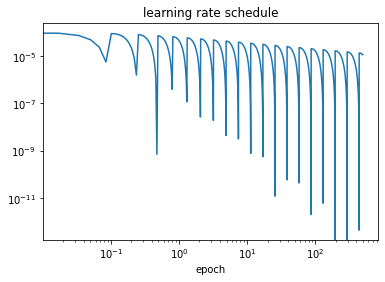

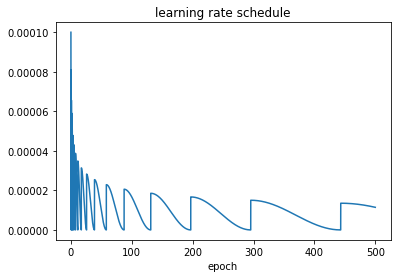

In [44]:
epochs=500
batch_size=32
total_number_of_points=X_train.shape[0]
n_cycles_per_epoch=10
# initial_lr=1e-2
initial_lr=1e-4
t_mul=1.5
m_mul=0.9
alpha=0.0
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
step = np.arange(0, epochs * steps_per_epoch)

lrs_kwargs = dict(
    epochs=epochs,
    batch_size=batch_size,
    total_number_of_points=total_number_of_points,
    n_cycles_per_epoch=n_cycles_per_epoch,
    initial_lr=initial_lr,
    t_mul=t_mul,
    m_mul=m_mul,
    alpha=alpha
)

lrs = lrs_fn(**lrs_kwargs)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()


In [45]:
%%time
model = build_model(scale=20, num_inducing=256, units=256)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lrs))
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    restore_best_weights=True
)

callbacks=[callback_es]
# callback_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=1e-8, cooldown=10)
# callbacks.append(callback_rlr)
# callbacks=None


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/500


2022-09-28 19:13:58.823129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 3s 28ms/step - loss: 0.1491 - val_loss: 0.1544
Epoch 2/500


2022-09-28 19:14:00.659077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 1s 20ms/step - loss: 0.1122 - val_loss: 0.1365
Epoch 3/500
59/59 [==============================] - 1s 20ms/step - loss: 0.0681 - val_loss: 0.0303
Epoch 4/500
59/59 [==============================] - 1s 18ms/step - loss: 0.0453 - val_loss: 0.0054
Epoch 5/500
59/59 [==============================] - 1s 19ms/step - loss: 0.0355 - val_loss: 0.0035
Epoch 6/500
59/59 [==============================] - 1s 19ms/step - loss: 0.0331 - val_loss: 9.0771e-04
Epoch 7/500
59/59 [==============================] - 1s 19ms/step - loss: 0.0266 - val_loss: 3.2510e-04
Epoch 8/500
59/59 [==============================] - 1s 20ms/step - loss: 0.0269 - val_loss: 0.0045
Epoch 9/500
59/59 [==============================] - 1s 23ms/step - loss: 0.0256 - val_loss: 0.0016
Epoch 10/500
59/59 [==============================] - 1s 23ms/step - loss: 0.0208 - val_loss: 2.6864e-04
Epoch 11/500
59/59 [==============================] - 1s 20ms/step - loss: 0.0183 - val_loss: 9.475

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 256)               512       
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                                 
 spectral_normalization_5 (S  (None, 256)              66304     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_6 (S  (None, 256)              66304     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_7 (S  (None, 256)              6630

In [47]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [48]:
plt.figure()
plt.plot(X, y)
plt.plot(X, model(X))

(-0.05, 0.03)

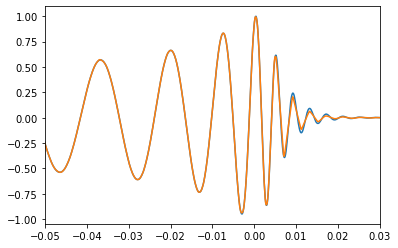

In [49]:
plt.figure()
plt.plot(X, y)
plt.plot(X, model(X))
plt.xlim(-0.05,0.03)

In [50]:
from pycbc.types import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096

# Generate the two waveforms to compare
delta_t = X[1]-X[0]
ts_1 = TimeSeries(y, delta_t=delta_t)
ts_2 = TimeSeries(model(X).numpy()[:,0], delta_t=delta_t, dtype=np.float64)

# Resize the waveforms to the same length
tlen = max(len(ts_1), len(ts_2))
ts_1.resize(tlen)
ts_2.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / ts_1.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(ts_1, ts_2, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.6f}'.format(m))

The match is: 0.999478


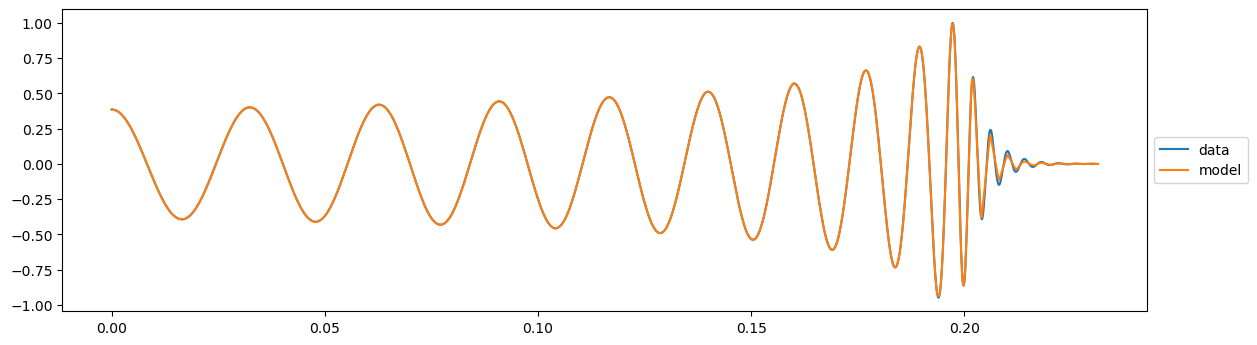

In [51]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(ts_1.sample_times, ts_1, label='data')
plt.plot(ts_2.sample_times, ts_2, label='model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))